## Facebook Friend Recommendation [M]

### Assignment :Tune hyperparameters for XG boost with all these features and check the error metric. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix

In [37]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

## Data

In [2]:
X_train = np.load('./dataset/train.npy')
X_test = np.load('./dataset/test.npy')
y_train = np.load('./dataset/ytrain.npy')
y_test = np.load('./dataset/ytest.npy')

In [3]:
X_train.shape

(15100030, 47)

In [4]:
X_test.shape

(3775008, 47)

In [5]:
y_train.shape

(15100030,)

In [6]:
y_test.shape

(3775008,)

## XGBoost

In [47]:
#https://github.com/johnphilip283/FacebookGraphML/tree/master/src/facebook
scores_train = defaultdict(float)
scores_test = defaultdict(float)

In [5]:
params = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
params['eval_metric'] = 'auc'

In [6]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)
watchlist = [(d_train, 'train'), (d_test, 'test')]

In [2]:
for eta in [0.001, 0.01, 0.1, 1]:
    params['eta'] = eta
    clf = xgb.train(params, d_train, 200, watchlist, 
                    early_stopping_rounds=20, verbose_eval=1)
    predict_y_train = clf.predict(d_train)
    auc_train = roc_auc_score(y_train, predict_y_train)
    predict_y_test = clf.predict(d_test)
    auc_test = roc_auc_score(y_test, predict_y_test)
    print('Test AUC: ', auc_test)
    scores_train[eta] = auc_train
    scores_test[eta] = auc_test

In [71]:
scores_train_df = pd.DataFrame([*scores_train.items()], columns=['eta', 'train_auc'])
scores_test_df = pd.DataFrame([*scores_test.items()], columns=['eta', 'test_auc'])
scores = pd.merge(scores_train_df, scores_test_df, on='eta')
scores_plot = pd.melt(scores, id_vars='eta', var_name='subset', value_name='auc')

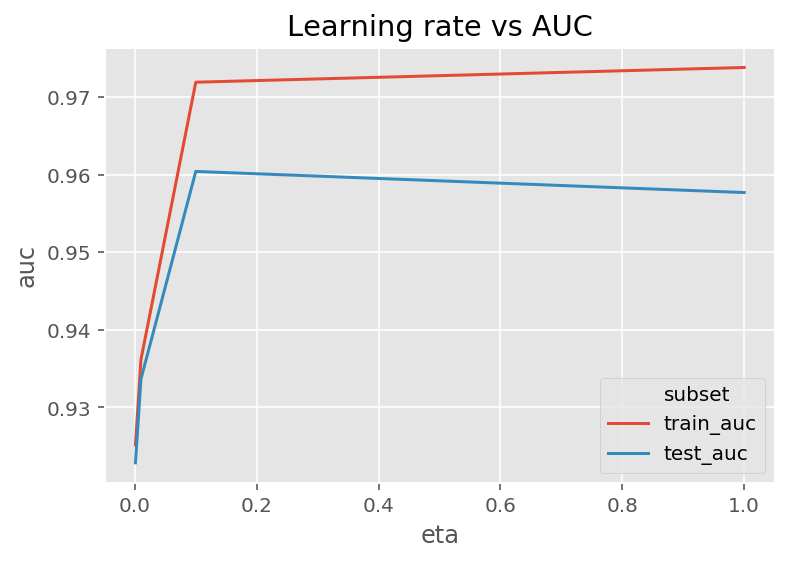

In [72]:
sns.lineplot(x='eta', y='auc', hue='subset', data=scores_plot);
plt.title('Learning rate vs AUC');

In [77]:
scores.sort_values(by='test_auc', inplace=True, ascending=False)
best_xgb = scores.iloc[0]

In [86]:
best_eta_xgb = best_xgb['eta']
best_train_auc_xgb = round(best_xgb['train_auc'], 4)
best_test_auc_xgb = round(best_xgb['test_auc'], 4)

## LightGBM
#### This is not mentioned in the Assgnment ,It was performed out of cuiosity as a leaning expeiment

In [90]:
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [94]:
params = {'num_leaves':150, 'objective':'binary',
          'max_depth':2,
          'learning_rate':1,
          'max_bin':200}
params['metric'] = 'auc'
num_round = 200

In [95]:
scores_train = defaultdict(float)
scores_test = defaultdict(float)

In [3]:
for eta in [0.001, 0.01, 0.1, 1]:
    params['learning_rate'] = eta
    clf = lgb.train(params, d_train, num_round, early_stopping_rounds=20, 
                    valid_sets=[d_train, d_test], valid_names=['train', 'test'])
#     clf = xgb.train(params, d_train, 200, watchlist, 
#                     early_stopping_rounds=20, verbose_eval=1)
    predict_y_train = clf.predict(X_train, num_iteration=clf.best_iteration)
    auc_train = roc_auc_score(y_train, predict_y_train)
    predict_y_test = clf.predict(X_test, num_iteration=clf.best_iteration)
    auc_test = roc_auc_score(y_test, predict_y_test)
    print('Test AUC: ', auc_test)
    scores_train[eta] = auc_train
    scores_test[eta] = auc_test

In [97]:
scores_train_df = pd.DataFrame([*scores_train.items()], columns=['eta', 'train_auc'])
scores_test_df = pd.DataFrame([*scores_test.items()], columns=['eta', 'test_auc'])
scores = pd.merge(scores_train_df, scores_test_df, on='eta')
scores_plot = pd.melt(scores, id_vars='eta', var_name='subset', value_name='auc')

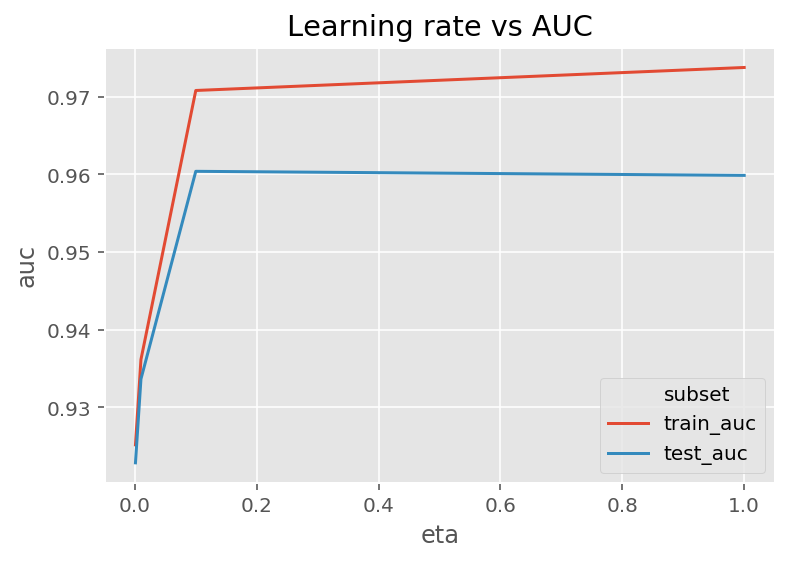

In [98]:
sns.lineplot(x='eta', y='auc', hue='subset', data=scores_plot);
plt.title('Learning rate vs AUC');

In [99]:
scores.sort_values(by='test_auc', inplace=True, ascending=False)
best_lgb = scores.iloc[0]

In [100]:
best_eta_lgb = best_lgb['eta']
best_train_auc_lgb = round(best_lgb['train_auc'], 4)
best_test_auc_lgb = round(best_lgb['test_auc'], 4)

## Feature Importance (LightGBM)

In [118]:
params['learning_rate'] = 0.1
clf = lgb.train(params, d_train, 200, early_stopping_rounds=20,
               valid_sets=[d_train, d_test], valid_names=['train', 'test'], verbose_eval=False)

In [124]:
features = ["source", "destination", "common_neighbors", "jaccard", "sorensen",
    "salton_cosine", "hub_promoted", "hub_depressed", "leicht_holme_nerman",
    "adamic_index", "preferential_attachment", "resource_allocation",
    "shortest_paths", "follows_back", "belongs_to_same_wcc", "pr_source",
    "pr_dest", "hits_source", "hits_dest", "katz_source", "katz_dest",
    "authority_source", "authority_dest", "num_follower_source",
    "num_followee_source", "num_follower_dest", "num_followee_dest",
    "inter_follower", "inter_followee", "weight_in", "weight_out",
    "weight_f1", "weight_f2", "weight_f3", "svd_source_1",
    "svd_source_2", "svd_source_3", "svd_source_4", "svd_source_5",
    "svd_source_6", "svd_destination_1", "svd_destination_2",
    "svd_destination_3", "svd_destination_4", "svd_destination_5",
    "svd_destination_6", "svd_dot"]

In [125]:
imp = clf.feature_importance()

In [130]:
imp_map = [*zip(features, imp)]

In [142]:
imp_map_df = pd.DataFrame(imp_map, columns=['feature', 'score'])
imp_map_df.sort_values(by='score', ascending=False, inplace=True)

In [143]:
imp_map_df['score'] = imp_map_df.score + 1 # To make features with 0 score visible

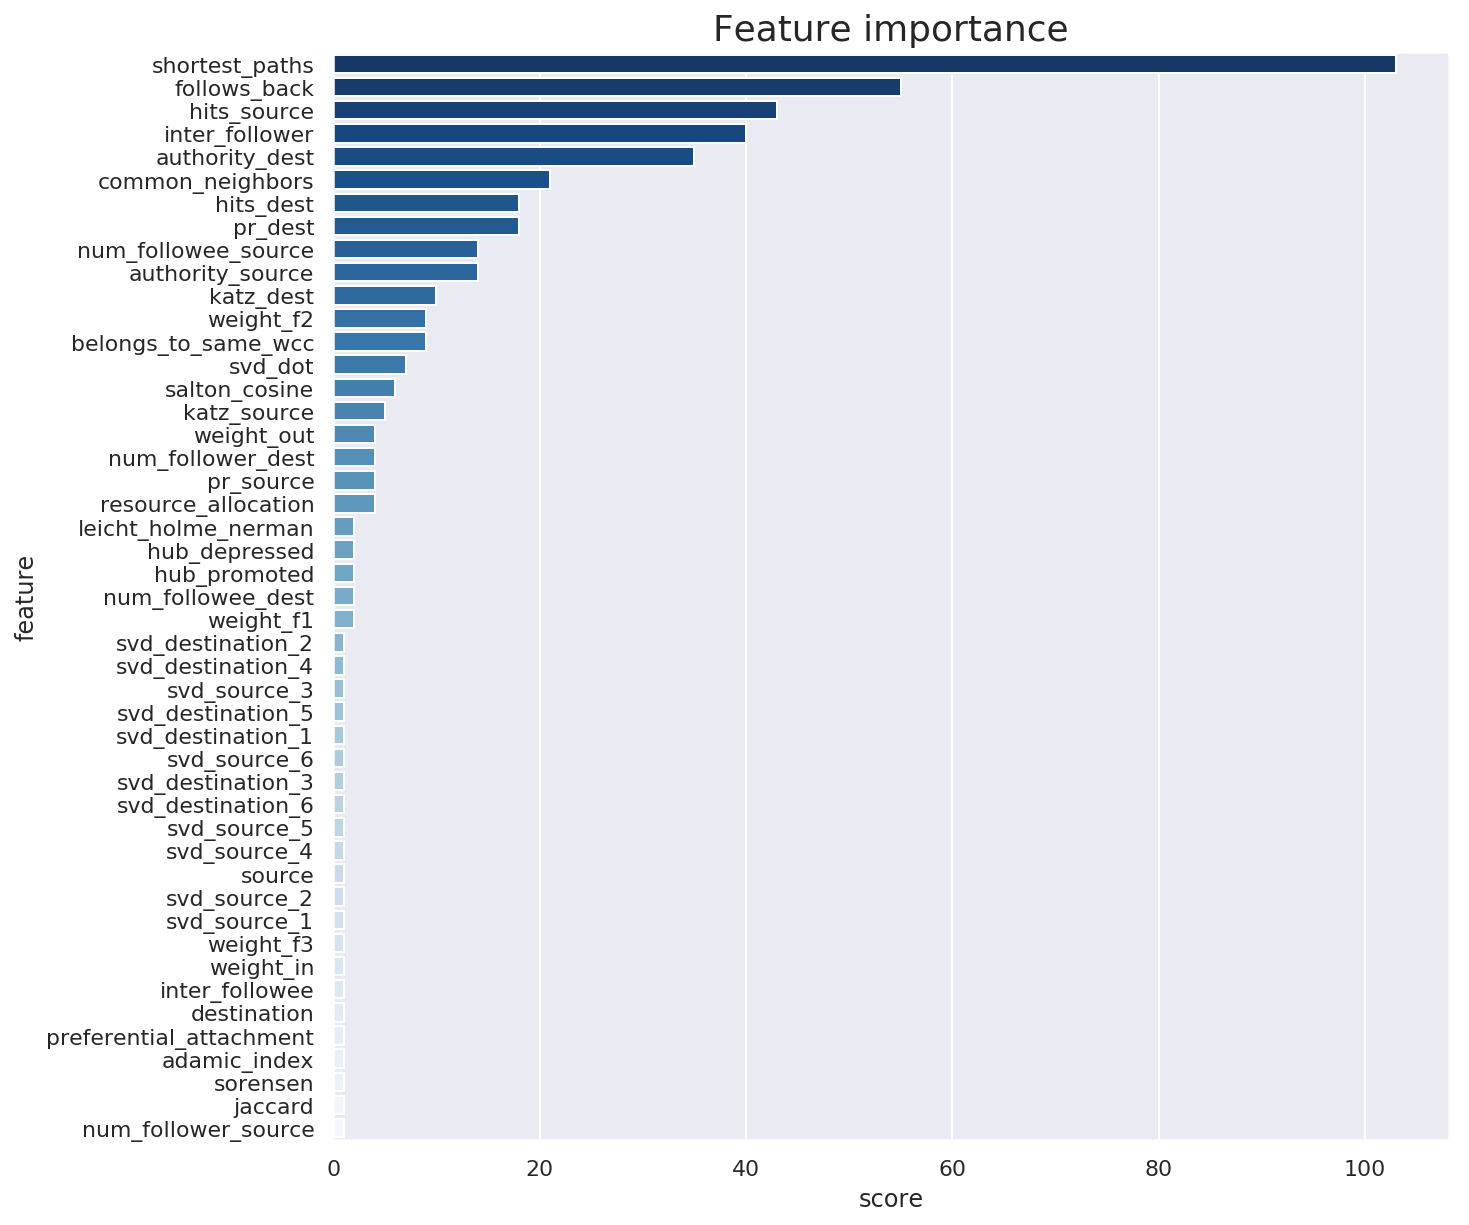

In [154]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.barplot(y='feature', x='score', data=imp_map_df, palette='Blues_r');
plt.title('Feature importance', fontsize=18);

## Conclusions

In [112]:
x = PrettyTable()
x.field_names = ["Algorithm", "Train AUC", 
                 "Test AUC", "learning rate", "Training time"]

In [113]:
x.add_row(["XGBoost", best_train_auc_xgb, best_test_auc_xgb, best_eta_xgb, "1+ hours"])
x.add_row(["LightGBM", best_train_auc_lgb, best_test_auc_lgb, best_eta_lgb, "15+ mintues"])
print(x)

+-----------+-----------+----------+---------------+---------------+
| Algorithm | Train AUC | Test AUC | learning rate | Training time |
+-----------+-----------+----------+---------------+---------------+
|  XGBoost  |   0.9719  |  0.9604  |      0.1      |    1+ hours   |
|  LightGBM |   0.9708  |  0.9604  |      0.1      |  15+ mintues  |
+-----------+-----------+----------+---------------+---------------+


- As Expected  LightGBM is better than XGboost if considered training time vs preformance.
- pagerank features are of lower importance than the Katz features 
- Most of the features made no effect while predicting the class label.
- Some featurisation played really well as compared to previously given feature set.

